In [53]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.core import Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import argparse
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [57]:
BATCH_SIZE = 12
EPOCH = 5

In [55]:
imageDataGenerator = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
#     shear_range=0.2,
#     zoom_range=0.2,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,)
train_datagen = imageDataGenerator.flow_from_directory(
        'data',
        target_size=(75, 75),
        batch_size=BATCH_SIZE,
#         color_mode='rgb',
        class_mode='binary')

Found 1704 images belonging to 1 classes.


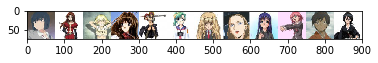

In [56]:
# imgs[0][0].shape
imgs = train_datagen.next()
imgs_grid = np.concatenate([imgs[0][i] for i in range(BATCH_SIZE)], axis=1)
plt.imshow(imgs_grid)

In [88]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024, activation='elu'))
    model.add(Dense(128*16*16, activation='elu'))
    model.add(Reshape((16, 16, 128)))
    model.add(BatchNormalization(axis=-1))
    model.add(UpSampling2D(size=(2, 2)))#增采样扩充，假装反池化
    model.add(Conv2DTranspose(64, 5, 5, activation='elu',kernel_initializer='truncated_normal'))
#     model.add(BatchNormalization(axis=-1))#for channel_last
    model.add(UpSampling2D(size=(2, 2)))#增采样扩充，假装反池化
    model.add(Conv2DTranspose(3, 4, 4, activation='elu',kernel_initializer='truncated_normal'))
#     model.add(Activation('tanh'))
    return model


In [92]:

def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, 4, 4,
                     activation='elu',
                     kernel_initializer='truncated_normal',
                    input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(128, 5, 5, 
                     activation='elu',
                     kernel_initializer='truncated_normal',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(BatchNormalization(axis=-1))
    model.add(Flatten())
    model.add(Dense(1024,activation='elu'))
    model.add(Dense(64,activation='elu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [52]:
def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [96]:
def train():
    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = generator_containing_discriminator(generator, discriminator)
    d_optim = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)
    g_optim = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)
    generator.compile(loss='binary_crossentropy', optimizer="Adam")
    discriminator_on_generator.compile(
        loss='binary_crossentropy', optimizer=g_optim)
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)
    noise = np.zeros((BATCH_SIZE, 100))
    for epoch in range(EPOCH):
        for index,data in enumerate(train_datagen,0):
            print("[%d/%d] [%d/%d]"%(epoch,EPOCH, index, BATCH_SIZE))
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)#uniform noise for each instance.
            image_batch = data[0]
            generated_images = generator.predict(noise, verbose=0)
            if index % 20 == 0:
                Image.fromarray(generated_images.astype(np.uint8)).save(
                    str(epoch)+"_"+str(index)+".png")
            print(image_batch.shape, generated_images.shape)
            X = np.concatenate((image_batch, generated_images))
            y = np.concatenate([np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)])
            d_loss = discriminator.train_on_batch(X, y)
            print("batch %d d_loss : %f" % (index, d_loss))
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)
            discriminator.trainable = False
            g_loss = discriminator_on_generator.train_on_batch(
                noise, [1] * BATCH_SIZE)
            discriminator.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
#             if index % 10 == 9:
#                 generator.save_weights('generator', True)
#                 discriminator.save_weights('discriminator', True)

In [97]:
train()

/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="elu", kernel_initializer="truncated_normal", input_shape=(75, 75, 3...)`
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), activation="elu", kernel_initializer="truncated_normal")`
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, activation="elu", units=1024)`
  app.launch_new_instance()
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(64, (5, 5), activation="elu", kernel_initializer="truncated_normal")`
/home/miller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update yo

[0/5] [0/12]


TypeError: Cannot handle this data type